In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
key=scio.loadmat('keyFile.mat')
psdVec=key['psdVec']
psdVec=psdVec.reshape(len(psdVec[0]))
print(psdVec.shape)

(1025,)


In [3]:
# load data
TrainingData = scio.loadmat('TrainingData.mat')
analysisData = scio.loadmat('analysisData.mat')

## Preparing
dataY = analysisData['dataVec'][0] # (2048,)
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
Fs = analysisData['sampFreq'][0,0] # 1024

# Search range of phase coefficients
rmin = [40, 1, 1]
rmax = [100, 50, 15]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
t = np.arange(0, nSamples*dt, dt) # (2048,)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
f = np.arange(0, Nyq+df, df) # Not used...(Herb)
[f, pxx1] = welch(TrainingData['trainData'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False)
pxx=pxx1/2
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

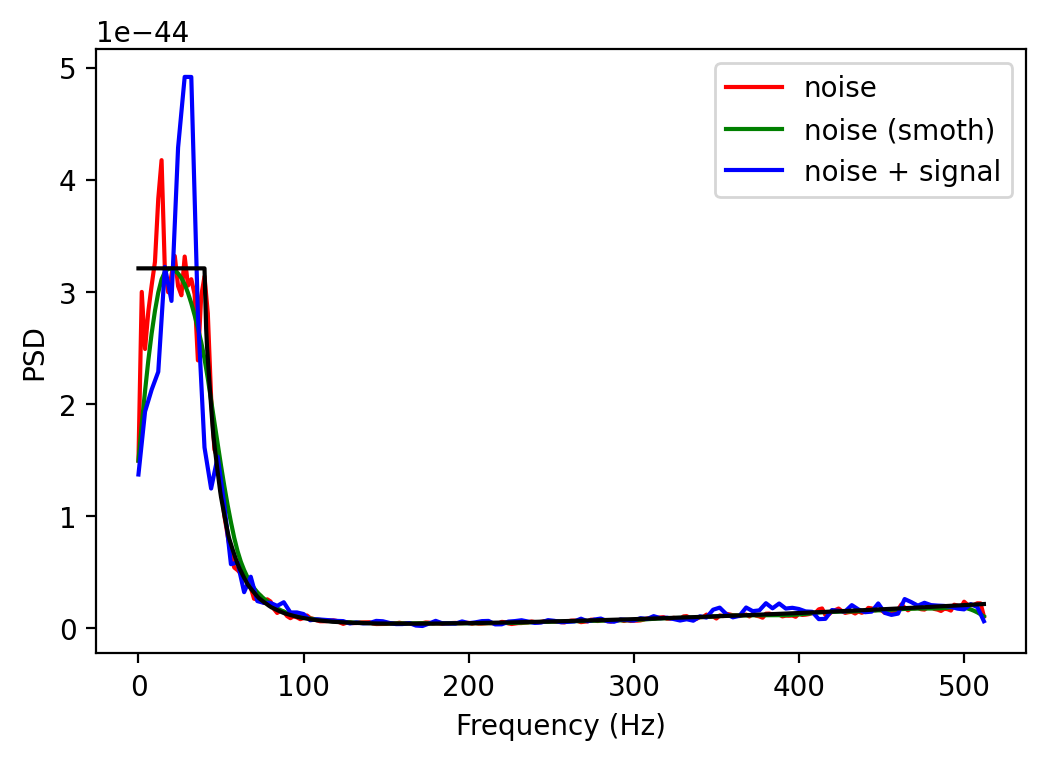

In [14]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx/2,'r', label='noise')
plt.plot(f,pxxSmth/2,'g', label='noise (smoth)')
[f_sm, pxxY1] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
pxxY=pxxY1/2
plt.plot(f_sm,pxxY/2,'b',label='noise + signal')
plt.plot(posFreq,psdVec,'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
#plt.savefig('output_psd.png', dpi=200)
plt.show()

In [5]:
# Number of independent PSO runs
nRuns = 8

In [6]:
%%time
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    'dataXSq': t**2,
    'dataXCb': t**3,
    'psdPosFreq': psdVec,#psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 71.95it/s]

Wall time: 3min 38s


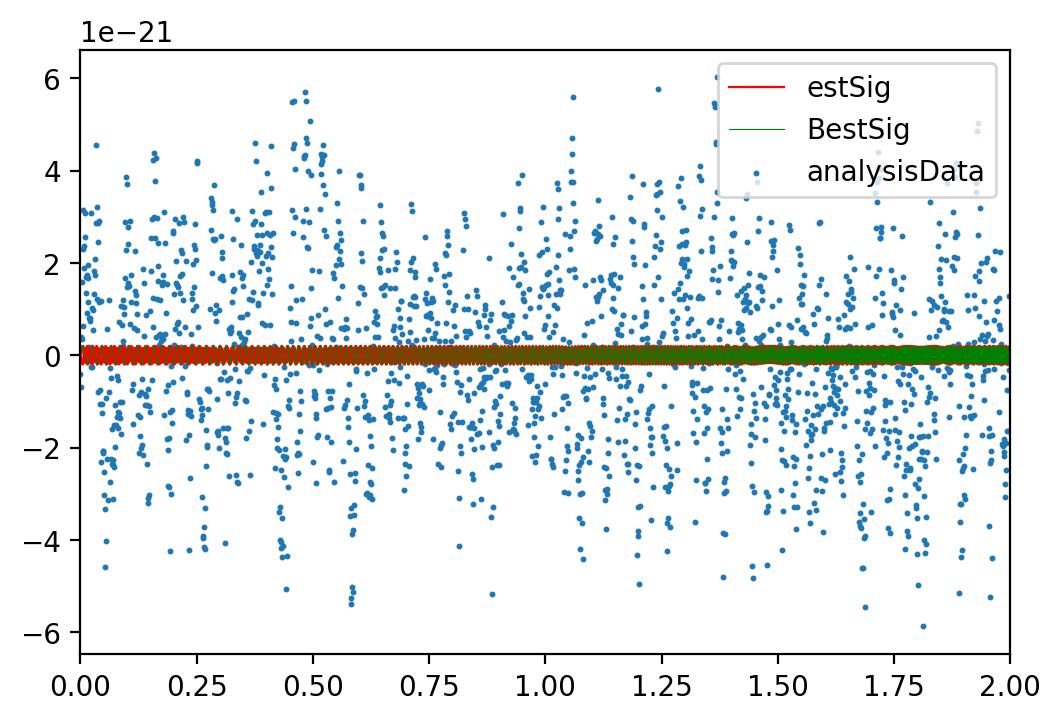

In [7]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color='r', lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         color='g',lw=.2*2)
c.set_label('BestSig')
plt.xlim(0,2)
plt.legend()
plt.savefig('output_sig_key.png', dpi=200)
plt.show()

In [8]:
# Print estimated parameters
print('Estimated parameters: a1={}; a2={}; a3={}; SNR={}'.format(outResults['bestQcCoefs'][0],
                                                         outResults['bestQcCoefs'][1],
                                                         outResults['bestQcCoefs'][2],
                                                                outResults['bestSNR']))
for lpruns in range(nRuns):
    print('\nRun No.{}:\nbestFitness={:.2f}'.format(lpruns+1, outStruct[lpruns]['bestFitness']) )
    print('a1={:.4f}; a2={:.4f}; a3={:.4f};SNR={:.4f}'.format(outResults['allRunsOutput'][lpruns]['qcCoefs'][0],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][1],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][2],
                                                  outResults['allRunsOutput'][lpruns]['SNR']))
# Save
np.save('output_results_key',outResults)
np.save('output_struct_key',outStruct)

Estimated parameters: a1=46.82132682550502; a2=32.90307562327721; a3=9.190925502866218; SNR=8.063694544901356

Run No.1:
bestFitness=-39.70
a1=62.2167; a2=19.2088; a3=13.0718;SNR=6.3005

Run No.2:
bestFitness=-43.43
a1=63.6587; a2=18.0054; a3=13.3809;SNR=6.5905

Run No.3:
bestFitness=-40.19
a1=58.7245; a2=20.6952; a3=13.0800;SNR=6.3397

Run No.4:
bestFitness=-55.03
a1=48.7679; a2=30.7620; a3=9.9013;SNR=7.4180

Run No.5:
bestFitness=-62.47
a1=48.8954; a2=30.9357; a3=9.7284;SNR=7.9036

Run No.6:
bestFitness=-36.35
a1=61.3755; a2=20.9417; a3=12.3125;SNR=6.0294

Run No.7:
bestFitness=-37.86
a1=62.3859; a2=20.1617; a3=12.5150;SNR=6.1531

Run No.8:
bestFitness=-65.02
a1=46.8213; a2=32.9031; a3=9.1909;SNR=8.0637


In [9]:
readdata=np.load('output_results_key.npy',allow_pickle=True)
print(readdata)

{'allRunsOutput': [{'fitVal': -39.69575438493969, 'qcCoefs': array([62.21667709, 19.20876562, 13.07184695]), 'estSig': array([-0.00000000e+00, -5.88613056e-23, -1.09269206e-22, ...,
        2.26534118e-23, -1.57190940e-22,  5.28559913e-23]), 'totalFuncEvals': 67926.0, 'SNR': 6.300456680665276}, {'fitVal': -43.4343560056404, 'qcCoefs': array([63.65865746, 18.00536756, 13.38086236]), 'estSig': array([ 0.00000000e+00,  6.28075144e-23,  1.16173732e-22, ...,
       -1.92355502e-23, -1.54289158e-22,  9.39524876e-23]), 'totalFuncEvals': 70770.0, 'SNR': 6.590474641908608}, {'fitVal': -40.192205803732854, 'qcCoefs': array([58.72448661, 20.69521759, 13.07997984]), 'estSig': array([-0.00000000e+00, -5.65851444e-23, -1.05927585e-22, ...,
        3.90709901e-24, -1.56090979e-22,  7.57903389e-23]), 'totalFuncEvals': 70121.0, 'SNR': 6.339732313255258}, {'fitVal': -55.02619714804373, 'qcCoefs': array([48.76794908, 30.76195402,  9.90132675]), 'estSig': array([-0.00000000e+00, -5.56273424e-23, -1.063621

In [10]:
readdata=np.load('output_struct_key.npy',allow_pickle=True)
print(readdata)

[{'totalFuncEvals': 67926.0, 'bestLocation': array([62.21667709, 19.20876562, 13.07184695]), 'bestFitness': -39.69575438493969}
 {'totalFuncEvals': 70770.0, 'bestLocation': array([63.65865746, 18.00536756, 13.38086236]), 'bestFitness': -43.4343560056404}
 {'totalFuncEvals': 70121.0, 'bestLocation': array([58.72448661, 20.69521759, 13.07997984]), 'bestFitness': -40.192205803732854}
 {'totalFuncEvals': 69080.0, 'bestLocation': array([48.76794908, 30.76195402,  9.90132675]), 'bestFitness': -55.02619714804373}
 {'totalFuncEvals': 70734.0, 'bestLocation': array([48.89535179, 30.93566906,  9.72839054]), 'bestFitness': -62.46730789898919}
 {'totalFuncEvals': 70724.0, 'bestLocation': array([61.37548898, 20.9417127 , 12.31251255]), 'bestFitness': -36.353694148764816}
 {'totalFuncEvals': 70623.0, 'bestLocation': array([62.38593302, 20.16173354, 12.5149512 ]), 'bestFitness': -37.86050621851914}
 {'totalFuncEvals': 71613.0, 'bestLocation': array([46.82132683, 32.90307562,  9.1909255 ]), 'bestFitne